# Study of the proposal density $\Sigma_p$
26.9.16

## Current state
The default option `Config(propvar=uniformpropvar(0.1))` results in a isotropic Gaussian proposal distribution with componentwise covariance of `log(1+0.1^2)` in the logspace, representing a standard deviation of 10%.
(TODO: proof)

This is just the initial proposition, which gets adapted by a running covariance estimate along the MC.
Since the adaption itsself involves cholesky factorization it is time intensive and due to the random MC is random itsself, thus probably further weakening reprocuducability.

Instead of recalculating the adaptive proposal over and over again, it seems reasonable to incorporate all simulations taken so far to estimate a single, fixed proposal for simplicity.


## Goal of the proposal density
The goal of finding the right proposal density is to speed up the Markov Chain convergence,
choosing the steps to small leads too many evaluations due to the autocorrelation,
choosing them too large results in many unfeasible jumps, thus rejecting a lot of the computation.

In theory (for Gaussian targets) a acceptance/rejection ratio of ~0.4 is optimal.

## Improvement
Since we already have samplings I would like to incorporate the results from the previous results.

A common choice based on an target distribution covariance estimation $\Sigma_t$ (c.f. Roberts, Rosenthal), also used in the used AMM sampler for adaptive updates, is
$$ \Sigma_p = 2.38^2\Sigma_t  / n$$
with `n` $n$ the dimension of the parameterspace and 2.38 an optimality constant (for Gaussian targets). 

Since we have different samplings of individual persons targets, it is not clear though how to estimate $\Sigma_p$.
Imagine for example S1 and S2 beeing two samples of two persons, which are just slightly shifted.
Here the optimal proposal for S1 and S2 would be similar, but taking the covariance of the combined sampling results in a higher covariance.

A straighforward approach would be using the componentwise means of the covariances.

## Problems
Since the covariance matrices are high-dimensional, we need some statistics/metric to examine/compare them.
- Since we are in log-parameterspace the trace of the covariance gives a good indication of the (relative) amount of variation

# Examining some samplings

In the following we will load and examine some of the latest samplings

In [2]:
using GynC
ss=cd("../data/0729") do 
    map(GynC.load, readdir()[2:end])
end

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/numerik/bzfsikor/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/numerik/bzfsikor/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/numerik/bzfsikor/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/numerik/bzfsikor/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    promote_rule(Type{Mamba.ScalarLogical}, Type{##107#T<:Real}) at /home/numerik/bzfsikor/.julia/v0.4/Mamba/src/variate.jl:20
is ambiguous with: 
    promote_rule(Type{#A<:Real}, Type{ForwardDiff

12-element Array{GynC.Sampling,1}:
 Sampling
  samples: (300000,116)
  uniques: 49475
  config:  Config:
 patient: l1
 sigma:   0.1
 propvar trace: 0.00011599994199049544
 adapt:   true
 thin:    100
 init:    4858380976513133059
 prior:   Tuple{Array{Distributions.Distribution{Distributions.Univariate,S<:Distributions.ValueSupport},1},Distributions.MixtureModel{Distributions.Multivariate,Distributions.Continuous,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}}
 Sampling
  samples: (300000,116)
  uniques: 41284
  config:  Config:
 patient: l1
 sigma:   0.1
 propvar trace: 0.011599420038662503
 adapt:   true
 thin:    100
 init:    4858380976513133059
 prior:   Tuple{Array{Distributions.Distribution{Distributions.Univariate,S<:Distributions.ValueSupport},1},Distributions.MixtureModel{Distributions.Multivariate,Distributions.Continuous,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}}  
 Sampling
  sam

In [3]:
scale = 2.38^2 / size(ss[1].samples, 2)
@time data = vcat(map(ss) do s
    DataFrames.DataFrame(
      person=s.config.patient.id,
      sigma =s.config.sigma_rho,
      adapt = s.config.adapt,
      thin  = s.config.thin,
      length=size(s.samples,1),
      unique=length(unique(s.samples[:,1])),
      tracepropinit = let L = s.variate.tune.SigmaL; trace(L*L') end,
      tracepropadapt = let L = s.variate.tune.SigmaLm; trace(L*L') end,
      scaledlogcovtrace = trace(cov(log(s.samples))) * scale) #coincides with the above
end ...)

 42.404907 seconds (1.88 M allocations: 6.373 GB, 1.22% gc time)


,person,sigma,adapt,thin,length,unique,tracepropinit,tracepropadapt,scaledlogcovtrace
1,l1,0.1,true,100,300000,49475,0.00011599994199049544,1.358015432779355,1.3580216637923535
2,l1,0.1,true,100,300000,41284,0.011599420038662505,0.9570805656575443,0.9570812405229294
3,l1,0.1,true,100,300000,30085,1.1542383789674993,1.5468214537321763,1.5467968972600412
4,l1,0.1,true,100,300000,54800,1.1599999871501336e-6,1.0334367413177026,1.0334234671690028
5,l2,0.1,true,100,300000,44763,0.00011599994199049544,1.1977611248813995,1.1977676875482004
6,l2,0.1,true,100,300000,57754,0.011599420038662505,1.352205868184559,1.3521971029139637
7,l2,0.1,true,100,300000,34886,1.1542383789674993,2.971847779000214,2.971849472147304
8,l2,0.1,true,100,300000,65899,1.1599999871501336e-6,1.1294641342713472,1.1294583655742374
9,l3,0.1,true,100,300000,50250,0.00011599994199049544,1.0884472155123615,1.0884143652836638
10,l3,0.1,true,100,300000,32656,0.011599420038662505,0.8911885871126404,0.8911760260035788


The adaptive trace seems to be mostly independent from the initial proposal density.
Still, the chains exhibit quite different covariances, even for the same persons, indicating that the 3 Million samples might not suffice.

Now let us compute the corresponding trace for the merged sampling:

In [4]:
trace(cov(log(vcat([s.samples for s in ss]...)))) * scale

3.527998930059974

This seems to overestimate the chain variances, probably because of different persons means.
Let's test the same restricted to each person respectively:

In [5]:
[trace(cov(log(vcat([s.samples for s in ss[(1:4)+(4*i)]]...)))) * scale for i=0:2]

3-element Array{Any,1}:
 3.03694
 3.8306 
 2.49903

In [6]:
[mean(s.samples[:,8]) for s in ss]

12-element Array{Any,1}:
 9.19417
 5.72153
 6.72323
 5.4335 
 5.87349
 5.72292
 4.52528
 7.91079
 8.08296
 6.36484
 7.92521
 3.39084

Since not even the means converged, the adaptive proposals probably still underestimates the true covariance?

# Chain analysis

using Mamba's analysis tools.

Iterations = 100:29998100
Thinning interval = 2000
Chains = 1,2,3,4
Samples per chain = 15000

Gelman, Rubin, and Brooks Diagnostic:



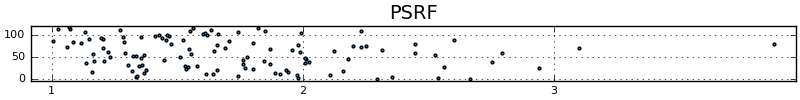


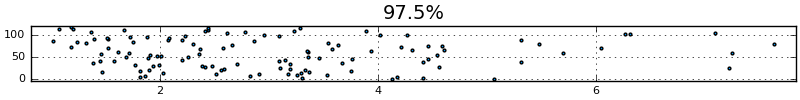

Iterations = 100:29998100
Thinning interval = 2000
Chains = 1,2,3,4
Samples per chain = 15000

Geweke Diagnostic:
First Window Fraction = 0.1
Second Window Fraction = 0.5




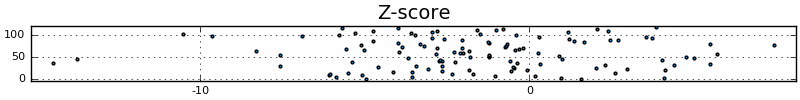


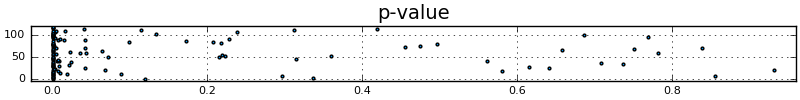

Iterations = 100:29998100
Thinning interval = 2000
Chains = 1,2,3,4
Samples per chain = 15000

Heidelberger and Welch Diagnostic:
Target Halfwidth Ratio = 0.1
Alpha = 0.05




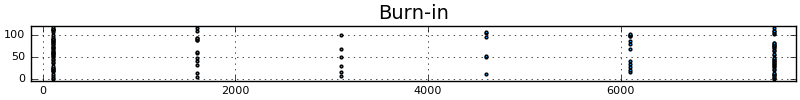


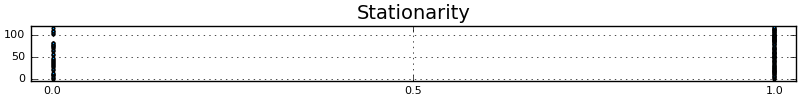


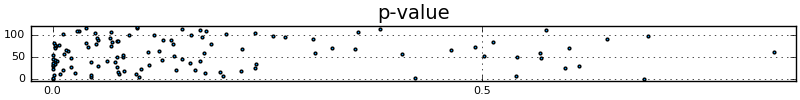


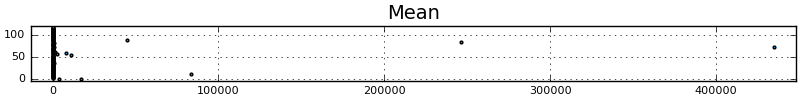


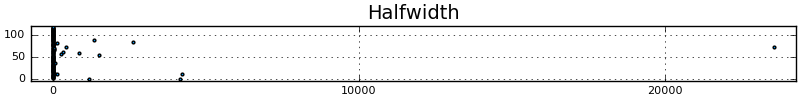


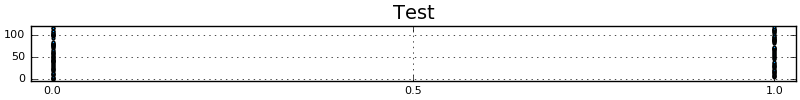

Iterations = 100:29998100
Thinning interval = 2000
Chains = 1,2,3,4
Samples per chain = 15000

Raftery and Lewis Diagnostic:
Quantile (q) = 0.025
Accuracy (r) = 0.005
Probability (s) = 0.95




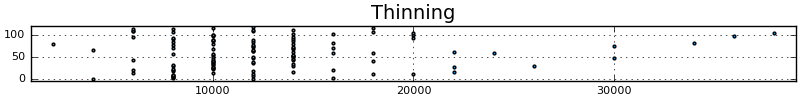


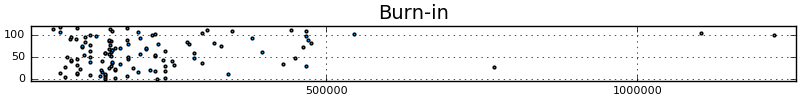


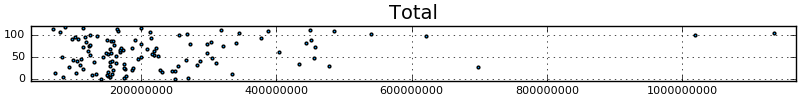


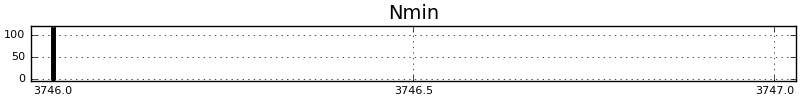


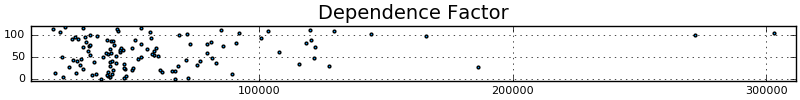

In [160]:
using Plots
import Plots.plot

function plot(s::Mamba.ChainSummary)
  inds = 1:size(s.value, 1)
  println(s.header)
  flush(STDOUT)
  for i = 1:length(s.colnames)
    scatter(s.value[:,i], inds, title = s.colnames[i], size=(800, 100), legend=false, ms=2) |> display
  end
end

function convergencediagnostic(cs::Mamba.AbstractChains)
    d = [Mamba.gelmandiag(cs),
    Mamba.gewekediag(cs), 
    Mamba.heideldiag(cs), 
    Mamba.rafterydiag(cs)]
    map(plot, d)
    d    
end

function convergencediagnostic(ss::Vector{Sampling}; burnin=0, extrathin=1)
    cs = cat(3, map(s->Mamba.Chains(s.samples, thin = s.config.thin, start = s.config.thin, names = GynC.samplednames), ss)...)
    cs = cs[1+burnin:extrathin:end,:,:]
    convergencediagnostic(cs)
end 

convergencediagnostic(ss[1:4], extrathin=20);